In [1]:
#import packages
import xarray as xr
import dask
import matplotlib.pyplot as plt
import numpy as np
import os


import matplotlib as mpl
import scipy
import glob as glob
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import calendar
import xskillscore as xs
from scipy.stats import iqr
import functools as ft
import cartopy.crs as ccrs
import matplotlib.patches as patches
from shapely import geometry
plt.rcParams['font.size'] = 14


In [11]:
#load in wind

In [12]:
datadir = '/home/z5113258/Documents/data/CMIP6_HB_new/'
#dict with file names
varis = {'tx':'_tauu.nc', 'ty':'_tauv.nc'}
models={}
#get all data for temp tendency
for model in os.listdir(datadir):
    #go thorugh all varis
    if model in ['NESM3']:
        pass
    else:
        mod={}
        for key in varis.keys():
            #input file
            inp_files = (os.path.join(datadir, model, str(model+varis[key])))
            try:
                #load in file
                var = xr.open_dataarray(inp_files)
                #put into dict
                mod[key]=var
            except Exception as e:
                print(e)
                pass
        #now append data to model dict
        models[model] = mod
del models["not_full"]

[Errno 2] No such file or directory: b'/home/z5113258/Documents/data/CMIP6_HB_new/not_full/not_full_tauu.nc'
[Errno 2] No such file or directory: b'/home/z5113258/Documents/data/CMIP6_HB_new/not_full/not_full_tauv.nc'


In [13]:
for i, mod in enumerate(models.keys()):
    tauu = models[mod]['tx']
    tauu = tauu.assign_coords({"model":i})
    if i == 0:
        tauum = tauu
    else:
        tauum = xr.concat([tauum, tauu], dim = 'model')
for i, mod in enumerate(models.keys()):
    tauv = models[mod]['ty']
    tauv = tauv.assign_coords({"model":i})
    if i == 0:
        tauvm = tauv
    else:
        tauvm = xr.concat([tauvm, tauv], dim = 'model')

In [14]:
tauuMM = tauum.median('model')
tauvMM = tauvm.median('model')

In [15]:
datadir = '/home/z5113258/Documents/data/REAN_HB/'
#dict with file names
varis = {'tx':'_tauu.nc', 'ty':'_tauv.nc'}
obs={}
#get all data for temp tendency
for model in os.listdir(datadir):
    #go thorugh all varis
    mod={}
    for key in varis.keys():
        #input file
        inp_files = (os.path.join(datadir, model, str(model+varis[key])))
        try:
            #load in file
            var = xr.open_dataarray(inp_files)
            #put into dict
            mod[key]=var
            #now append data to model dict
            obs[model] = mod
        except Exception as e:
            print(e)
            pass




[Errno 2] No such file or directory: b'/home/z5113258/Documents/data/REAN_HB/OAFLUX/OAFLUX_tauu.nc'
[Errno 2] No such file or directory: b'/home/z5113258/Documents/data/REAN_HB/OAFLUX/OAFLUX_tauv.nc'
[Errno 2] No such file or directory: b'/home/z5113258/Documents/data/REAN_HB/ORAS5/ORAS5_tauu.nc'
[Errno 2] No such file or directory: b'/home/z5113258/Documents/data/REAN_HB/ORAS5/ORAS5_tauv.nc'
[Errno 2] No such file or directory: b'/home/z5113258/Documents/data/REAN_HB/ARGO/ARGO_tauu.nc'
[Errno 2] No such file or directory: b'/home/z5113258/Documents/data/REAN_HB/ARGO/ARGO_tauv.nc'


In [17]:
#era5 wind stress
E5x = obs['ERA5']['tx']
E5y = obs['ERA5']['ty']

In [18]:
XB = tauuMM - E5x
YB = tauvMM - E5y

In [20]:
#make the wind bias quivers colors smaller
XBM = XB.sel(lat=slice(-30, 30),lon=slice(30, 130))
YBM = YB.sel(lat=slice(-30, 30),lon=slice(30, 130))

In [2]:
datadir = '/home/z5113258/Documents/data/CMIP6_HB_new/'
#dict with file names
varis = {'SST':'_tos.nc'}
SST_D={}
#get all data for temp tendency
for model in os.listdir(datadir):
    #go thorugh all varis
    if model in ['NESM3']:
        pass
    else:
        #input file
        inp_files = (os.path.join(datadir, model, str(model+"_tos.nc")))
        try:
            #load in file
            var = xr.open_dataarray(inp_files)
            #now append data to model dict
            SST_D[model] = var
        except Exception as e:
            print("Error. ", e)
            pass

Error.  [Errno 2] No such file or directory: b'/home/z5113258/Documents/data/CMIP6_HB_new/not_full/not_full_tos.nc'


In [3]:
#now get models timeseries
for i, model in enumerate(SST_D.keys()):
    try:    
        sst = SST_D[model]
        #now turn into an array
        if i == 0:
            SSTM = sst
        else:
            SSTM = xr.concat([SSTM, sst], dim = 'model')
    except Exception as e:
            print("something went wrong, here is the error code", e)

In [4]:
#load in SST to compare to
OSST = xr.open_mfdataset('/home/z5113258/Documents/data/NOAA_OISSTv2.nc', parallel=True).sst
LSM = xr.open_dataset('/home/z5113258/Documents/data/LSM.nc').mask
OSST= OSST.where(LSM[0])
OSST = OSST.groupby('time.month').mean('time').sel(lat=slice(-40,30),lon=slice(30,125))

In [5]:
#calculate bias and the significance levels
SSTB = SSTM - OSST
#find cells where pos and negative
SSTB_pos = xr.where(SSTB>0, 1,0)
SSTB_neg = xr.where(SSTB<0, 1,0)
#get where majority of cells agree on sign, ie, at least 15/20
SSTB_pos_ = SSTB_pos.sum('model')
pos = xr.where(SSTB_pos_ >= 15, 1, 0)

SSTB_neg_ = SSTB_neg.sum('model')
neg = xr.where(SSTB_neg_ >= 15, 1, 0)
sigbias = xr.where((pos+neg)==1, 1, np.nan)

In [6]:
#make a land sea mask
SEA = SSTB.mean('month').median('model')
SEA1 = SEA.fillna(-99)
LSM = SEA1.where(SEA1==-99, drop=True)

/home/z5113258/anaconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/z5113258/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


In [7]:
SSTB = SSTB.where(sigbias == 1, 0)

In [8]:
SSTB

<xarray.DataArray (model: 20, month: 12, lat: 60, lon: 95)>
dask.array<where, shape=(20, 12, 60, 95), dtype=float32, chunksize=(20, 1, 60, 95), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -29.5 -28.5 -27.5 -26.5 -25.5 ... 26.5 27.5 28.5 29.5
  * lon      (lon) float64 30.5 31.5 32.5 33.5 34.5 ... 121.5 122.5 123.5 124.5
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Dimensions without coordinates: model

In [9]:
SSTbias = SSTB.where(abs(SSTB) > 0)

# Main panel

/home/z5113258/anaconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/z5113258/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
/home/z5113258/anaconda3/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1763: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  result = matplotlib.axes.Axes.pcolor(self, *args, **kwargs)
/home/z5113258/anaconda3/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/hom

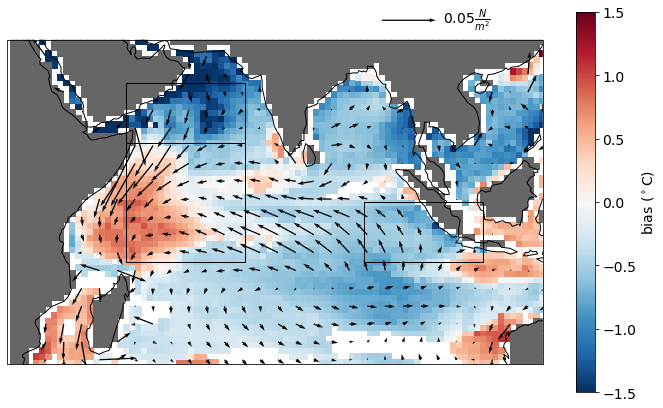

In [21]:
import matplotlib.patches as patches
fig = plt.figure(figsize = (12,7))
#mean wind bias
XBMa = XBM.mean('month')
YBMa = YBM.mean('month')

ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
C = ax.pcolor(SSTbias.lon, SSTbias.lat, SSTbias.median('model').mean('month'), 
          transform=ccrs.PlateCarree(), vmin = -1.5, vmax = 1.5, cmap = 'RdBu_r')
ax.pcolor(LSM.lon, LSM.lat, LSM, transform=ccrs.PlateCarree(),cmap = 'Accent_r')
fig.colorbar(C, ax=ax, label = "bias ($^\circ$C)")
Q = ax.quiver(XBM.lon[::3], XBM.lat[::3], XBMa[::3,::3], YBMa[::3,::3], 
                  transform=ccrs.PlateCarree(), scale = 0.5)

#plt.title('Annual mean wind bias')
ax.coastlines()
qk = ax.quiverkey(Q, 0.8, 1.06, 0.05, r'$0.05 \frac{N}{m^2}$', labelpos='E',
                   coordinates='axes')
ax.add_patch(patches.Rectangle((50,-10), 20, 20, color="k", fill = False, linewidth=1, alpha = 1))
ax.add_patch(patches.Rectangle((50,10), 20, 10, color="k", fill = False, linewidth=1, alpha = 1))
ax.add_patch(patches.Rectangle((90,-10), 20, 10, color="k", fill = False, linewidth=1, alpha = 1))
ax.set_facecolor('white')
ax.set_extent([30, 120, -20, 20])
#plt.savefig('bias_white_grey.eps')

In [25]:
#load in data
#loop to go through data folders. Do this in try except so that we know if/when somehting has failed, but the script will keep on running
datadir = '/home/z5113258/Documents/data/CMIP6_HB_new/'
#dict with file names
varis = {'dTdt':'_temp_tendency.nc', 'ua':'_u_advection.nc', 'va':'_v_advection.nc',
             'wa':'_w_advection.nc', 'lw':'_netLW.nc', 'sw':'_netSW.nc', 'lhf':'_hfls.nc', 
             'shf':'_hfss.nc', 'SST': '_tos.nc'}
models={}
#get all data for temp tendency
var = 'thetao/*.nc'
for model in os.listdir(datadir):
    #go thorugh all varis
    if model == 'NESM3':
        pass
    else:
        mod={}
        for key in varis.keys():
            #input file
            inp_files = (os.path.join(datadir, model, str(model+varis[key])))
            try:
                #load in file
                var = xr.open_dataarray(inp_files)
                #put into dict
                mod[key]=var
                models[model] = mod

            except Exception as e:
                print(e)
                pass

[Errno 2] No such file or directory: b'/home/z5113258/Documents/data/CMIP6_HB_new/not_full/not_full_temp_tendency.nc'
[Errno 2] No such file or directory: b'/home/z5113258/Documents/data/CMIP6_HB_new/not_full/not_full_u_advection.nc'
[Errno 2] No such file or directory: b'/home/z5113258/Documents/data/CMIP6_HB_new/not_full/not_full_v_advection.nc'
[Errno 2] No such file or directory: b'/home/z5113258/Documents/data/CMIP6_HB_new/not_full/not_full_w_advection.nc'
[Errno 2] No such file or directory: b'/home/z5113258/Documents/data/CMIP6_HB_new/not_full/not_full_netLW.nc'
[Errno 2] No such file or directory: b'/home/z5113258/Documents/data/CMIP6_HB_new/not_full/not_full_netSW.nc'
[Errno 2] No such file or directory: b'/home/z5113258/Documents/data/CMIP6_HB_new/not_full/not_full_hfls.nc'
[Errno 2] No such file or directory: b'/home/z5113258/Documents/data/CMIP6_HB_new/not_full/not_full_hfss.nc'
[Errno 2] No such file or directory: b'/home/z5113258/Documents/data/CMIP6_HB_new/not_full/not_f

In [26]:
#load in REAn products with all HB terms
#loop to go through data folders. Do this in try except so that we know if/when somehting has failed, but the script will keep on running
datadir = '/home/z5113258/Documents/data/REAN_HB/'
#dict with file names
varis = {'dTdt':'_temp_tendency.nc', 'ua':'_u_advection.nc', 'va':'_v_advection.nc',
             'wa':'_w_advection.nc', 'q':'_qnet.nc', 'SST': '_tos.nc'}
OBS={}
#get all data for temp tendency
var = 'thetao/*.nc'
for model in os.listdir(datadir):
    #go thorugh all varis
    if model == 'NESM3':
        pass
    else:
        mod={}
        for key in varis.keys():
            #input file
            inp_files = (os.path.join(datadir, model, str(model+varis[key])))
            try:
                #load in file
                var = xr.open_dataarray(inp_files)
                #put into dict
                mod[key]=var
                OBS[model] = mod

            except Exception as e:
                print(e)
                pass

[Errno 2] No such file or directory: b'/home/z5113258/Documents/data/REAN_HB/OAFLUX/OAFLUX_temp_tendency.nc'
[Errno 2] No such file or directory: b'/home/z5113258/Documents/data/REAN_HB/OAFLUX/OAFLUX_u_advection.nc'
[Errno 2] No such file or directory: b'/home/z5113258/Documents/data/REAN_HB/OAFLUX/OAFLUX_v_advection.nc'
[Errno 2] No such file or directory: b'/home/z5113258/Documents/data/REAN_HB/OAFLUX/OAFLUX_w_advection.nc'
[Errno 2] No such file or directory: b'/home/z5113258/Documents/data/REAN_HB/OAFLUX/OAFLUX_tos.nc'
[Errno 2] No such file or directory: b'/home/z5113258/Documents/data/REAN_HB/ERA5/ERA5_temp_tendency.nc'
[Errno 2] No such file or directory: b'/home/z5113258/Documents/data/REAN_HB/ERA5/ERA5_u_advection.nc'
[Errno 2] No such file or directory: b'/home/z5113258/Documents/data/REAN_HB/ERA5/ERA5_v_advection.nc'
[Errno 2] No such file or directory: b'/home/z5113258/Documents/data/REAN_HB/ERA5/ERA5_w_advection.nc'
[Errno 2] No such file or directory: b'/home/z5113258/Doc

In [27]:
#reverse signs on advection, pack Qnet nad HF terms separately
models1={}
model_HF={}
for model in models.keys():
    try:
        HB=models[model]
        T=HB['dTdt']
        U=HB['ua']
        V=HB['va']
        W=HB['wa']
        lw=HB['lw']
        sw=HB['sw']
        lhf=HB['lhf']
        shf=HB['shf']
        Q=(lw+sw-lhf-shf)/(3986*1026*50)#terms are all positive so have to add in sign, and scale to degC/month
        SST = HB['SST']
        resid = T-Q+U+V+W
        #repack dict with correct sign so everything is additive
        HB1={'dTdt':T, 'ua':-U, 'va':-V,'wa':-W, 'q':Q, 'res':resid, 'SST':SST}
        #pack HF terms into different dict
        HF={'lw':lw, 'sw':sw, 'lhf':-lhf, 'shf':-shf, 'q':Q}
        model_HF[model]=HF
        models1[model]=HB1
    except Exception as e:
        print(e, model)
#do the same for OBS
OBS1={}
for model in OBS.keys():
    try:
        HB=OBS[model]
        T=HB['dTdt']
        U=HB['ua']
        V=HB['va']
        W=HB['wa']
        Q=HB['q']
        SST = HB['SST']
        resid = T-Q+U+V+W
        #repack dict
        HB1={'dTdt':T, 'ua':-U, 'va':-V,'wa':-W, 'q':Q, 'res':resid, 'SST':SST}
        OBS1[model]=HB1
    except Exception as e:
        print(e, model)

'dTdt' OAFLUX
'dTdt' ERA5
'ua' ARGO


In [22]:
def get_model_TS(MM_D):
    for i, model in enumerate(MM_D.keys()):
        HB = MM_D[model]
        T=HB['dTdt']
        U=HB['ua']
        V=HB['va']
        W=HB['wa']
        Q=HB['q']
        resid = HB['res']
        SST = HB['SST']

        T=T.assign_coords({'model':model})
        U=U.assign_coords({'model':model})
        V=V.assign_coords({'model':model})
        W=W.assign_coords({'model':model})
        Q=Q.assign_coords({'model':model})
        resid = resid.assign_coords({'model':model})
        SST = SST.assign_coords({'model':model})
        #now turn all these variables into an array
        if i == 0:
            TM = T
            UM = U
            VM = V
            WM = W
            QM = Q
            RM = resid
            SM = SST
        else:
            TM = xr.concat([TM, T], dim = 'model')
            UM = xr.concat([UM, U], dim = 'model')
            VM = xr.concat([VM, V], dim = 'model')
            WM = xr.concat([WM, W], dim = 'model')
            QM = xr.concat([QM, Q], dim = 'model')
            RM = xr.concat([RM, resid], dim = 'model')
            SM = xr.concat([SM, SST], dim = 'model')
    return TM, UM, VM, WM, QM, RM, SM

In [29]:
def get_region(da, lat, lat_r, lon, lon_r):
    DA_ss = da.sel(lat=slice(lat, lat_r),lon=slice(lon, lon_r)).mean(['lat', 'lon'])
    return DA_ss

In [30]:
def get_SSTBIAS(MM_D, lat, lat_r, lon, lon_r):
    #create a 'model-series' for each variable
    TM, UM, VM, WM, QM, RM, SM = get_model_TS(MM_D)
    #Now calculate the multimodel means/
    TMM = SM.median(dim = 'model')
    T_argo = OBS['ARGO']['SST']
    diff = get_region((TMM), lat, lat_r, lon, lon_r) - get_region((T_argo), lat, lat_r, lon, lon_r)
    return diff

In [31]:
WTIO = get_SSTBIAS(models1, -10,10, 50,70)
SETIO = get_SSTBIAS(models1, -10,0, 90,110)
AS = get_SSTBIAS(models1, 10,20, 50,70)

# Arabian sea SST bias

([], [])

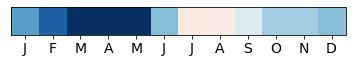

In [32]:
plt.imshow([AS], cmap = 'RdBu_r', vmin = -1.5, vmax = 1.5)
plt.xticks(range(0,12), ['J','F','M','A','M','J','J','A','S','O','N','D'])   
plt.yticks([])

# WTIO SST bias

([], [])

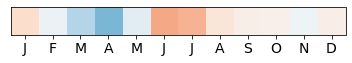

In [33]:
plt.imshow([WTIO], cmap = 'RdBu_r', vmin = -1.5, vmax = 1.5)
plt.xticks(range(0,12), ['J','F','M','A','M','J','J','A','S','O','N','D'])   
plt.yticks([])

# SETIO SST bias

([], [])

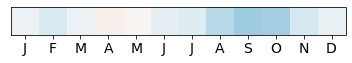

In [35]:
plt.imshow([SETIO], cmap = 'RdBu_r', vmin = -1.5, vmax = 1.5)
plt.xticks(range(0,12), ['J','F','M','A','M','J','J','A','S','O','N','D'])   
plt.yticks([])